# Assisting Blind People Navigate Cities via Object Recognition

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement-&amp;-Methodology" data-toc-modified-id="Problem-Statement-&amp;-Methodology-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement &amp; Methodology</a></span></li><li><span><a href="#Creating-and-activating-the-environment-for-model-training:" data-toc-modified-id="Creating-and-activating-the-environment-for-model-training:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating and activating the environment for model training:</a></span></li><li><span><a href="#Image-&amp;-Video-Processing" data-toc-modified-id="Image-&amp;-Video-Processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Image &amp; Video Processing</a></span></li><li><span><a href="#Labeling-images" data-toc-modified-id="Labeling-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Labeling images</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Object-Recognition" data-toc-modified-id="Object-Recognition-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Object Recognition</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Problem Statement & Methodology

Walking without sight brings the risk of falls and collisions. Such accidents often require medical condition and can change the walking habits of blind people and reduce their confidence as independent travelers. 

How do we reduce the risk of such accidents? One of the ways we can assist blind people is by providing them with description of the objects in their field of view.

My goal for this project is to develop an object detection model which would provide a detailed descriptions of objects in the field of view to assist blind people navigate around cities.

The general approach involved in this project is image preprocessing. Image feature extraction using pre-trained models. I built an object detection model with 5 classes (person, pole, tree, traffic light, and car). For this, I took pictures and videos of my neighborhood in San Jose and labeled each objects in the image using LabelImg. Trained the model and tested the object detection model to find out if it can detect the objects we have trained it on.

## Creating and activating the environment for model training:

1. conda create --name tf-object-detection python=3.7.4
2. conda activate tf-object-detection

__Choose a folder you want to work at and create a directory named "tensorflow":__

../tensorflow

__Clone the Tensorflow models repository:__

git clone https://github.com/tensorflow/models=1.13

__Install all dependencies:__

1. conda install Cython
2. conda install contextlib2
3. conda install pillow
4. conda install lxml
5. conda install jupyter
6. conda install matplotlib
7. conda install tensorflow=1

__Install the COCO API:__

git clone https://github.com/cocodataset/cocoapi.git

cd cocoapi/PythonAPI

make

cp -r pycocotools ../research

__Protobuf installation and compilation:__

protoc object_detection/protos/*.proto --python_out=.

__Add necessary environment variables:__

export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

python setup.py build

python setup.py install

__Gathering data:__

I used my iPhone camera to take images (~300) of different regions in my neighborhood in San Jose. I converted the images to jpg and resized the images (code is provided below) so that the training step is not too time consuming. 

## Image & Video Processing

__Converting Video to Set of Images:__

In [3]:
vidcap = cv2.VideoCapture('../IMG_2.mov')
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite("../sanjose2/frame%d.jpg" % count, image)     # save frame as JPEG file
    success,image = vidcap.read()
    count += 1

__Resizing Images:__

In [4]:
path = "../sanjose2/"
save_folder = "../sanjose2_resized/"
resize_ratio = 0.25

def resize_aspect_fit():
    dirs = os.listdir(path)
    for item in dirs:
        if item == '.jpg':
            continue
        if os.path.isfile(path+item):
            image = Image.open(path+item)
            print(item)
            file_path, extension = os.path.splitext(path+item)

            new_image_height = int(image.size[0] / (1/resize_ratio))
            new_image_length = int(image.size[1] / (1/resize_ratio))

            image = image.resize((new_image_height, new_image_length))
            image = image.rotate(0,expand=True)
            image.save(save_folder + item, quality=90)


resize_aspect_fit()

__Converting Set of Images to Video:__

In [5]:
image_folder = '../sanjose1_detected'
video_name = 'sanjose1.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for i in range(len(images)):
    video.write(cv2.imread(os.path.join(image_folder, "frame_"+str(i)+".png")))
    print(os.path.join("frame_"+str(i)+".png"))

cv2.destroyAllWindows()
video.release()

## Labeling images

I used LabelImg (https://github.com/tzutalin/labelImg) to label each objects in the images.

## Model Training

__Generating TFRecords for training:__

xml_to_csv.py and generate_tfrecord.py files helps with genrating such record files

__Training model:__

I used train.py in the object_detection/legacy folder to train the model. 

Below is the code used to train the model:

python train.py --logtostderr --model_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

__Checking training progress:__

tensorboard --logdir=training


## Importing Libraries

__Change Directory to Object Detection Folder Downloaded From Tensorflow:__

In [2]:
cd ../object_detection

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import PIL.Image
 
import cv2
import warnings
warnings.filterwarnings("ignore")

In [4]:
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Object Recognition

__Note: The following part of the notebook is modified from Tensorflow object detection notebook!__

(279, 270, 3)


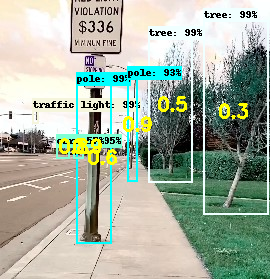

In [6]:
#Model name
MODEL_NAME = 'inference_graph1'
#Path to the saved model after training. I trained the model using earlier steps from my terminal. 
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
#Path to object labels. 
PATH_TO_LABELS = os.path.join('training1','labelmap.pbtxt')
#Number of classes. I have 5 classes (person, car, tree, traffic light, and pole) for this project.
NUM_CLASSES = 5
#Label map
label_map= label_map_util.load_labelmap(PATH_TO_LABELS)
#Different categories or labels
categories=label_map_util.convert_label_map_to_categories(label_map,max_num_classes=NUM_CLASSES,use_display_name=True)
category_index = label_map_util.create_category_index(categories)
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
#Path to test images for object recognition
PATH_TO_TEST_IMAGES_DIR = '../sanjose2_resized'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame{}.jpg'.format(i)) for i in range(0,1)]

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        #Loop through each images in the test folder
        for image_path in TEST_IMAGE_PATHS:
            #Open image
            image = PIL.Image.open(image_path)
            #Read image
            image_np = cv2.imread(image_path)
            #Expand dimensions of image
            image_np_expanded = np.expand_dims(image_np,axis=0)
            #Representing image as a tensor
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            #Bounding boxes for each object in the image
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            #Scores for each object detected in the image
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            #Different classes detected
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            #Number of classes detected
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            (boxes,scores,classes,num_detections)=sess.run(
                [boxes,scores,classes,num_detections],
                feed_dict={image_tensor:image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=2)
            
            
            #Image shape
            imgshape = image_np.shape
            #Choosing objects with scores >0.6
            true_boxes = boxes[0][scores[0] > 0.6]
            #Getting bounding box details 
            list_items = []
            #Getting object names
            list_names = []
            #Loop through each bounding boxes
            for i in range(true_boxes.shape[0]):
                #Get bounding box coordinates
                ymin = int(true_boxes[i,0]*imgshape[0])
                xmin = int(true_boxes[i,1]*imgshape[1])
                ymax = int(true_boxes[i,2]*imgshape[0])
                xmax = int(true_boxes[i,3]*imgshape[1])
                mydict = ((list(category_index.values())[int(classes[0][i])-1]))
                a = (mydict.get('name'),scores[0][i],xmin,ymin,xmax,ymax)
                list_items.append(a)
                list_names.append(mydict.get('name'))
#             print(list_names)
                
                
#                 print (mydict.get('name'))
#                 print(int(classes[0][i]) # print the class integer
                #print ("xmin ymin xmax ymax")
                #print (xmin,ymin,xmax,ymax)
            
            #Loop through each bounding boxes            
            for i,b in enumerate(boxes[0]):
                #Loop though each classes
                if classes[0][i] == 0 or classes[0][i] == 1 or classes[0][i] == 2 or classes[0][i] == 3 or classes[0][i] == 4:
                    #Consider if the score is larger or equal to 0.5
                    if scores[0][i] >= 0.5:
                        #Getting the coordinate of the center of the bounding boxes
                        mid_x = (boxes[0][i][3]+boxes[0][i][1])/2
                        mid_y = (boxes[0][i][2]+boxes[0][i][0])/2
                        #Getting approximate distance (it's a relative distance from 0-1) from the location of camera
                        apx_distance = round(((1 - (boxes[0][i][3] - boxes[0][i][1]))**4),1)
                        #Add location info. on the image
                        cv2.putText(image_np, '{}'.format(apx_distance), (int(mid_x*250),int(mid_y*279)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)
                    #Add a warning sign if the approximate distance is less than or equal to 0.5
                    if apx_distance <=0.5:
                        if mid_x > 0.2 and mid_x < 0.6:
                            cv2.putText(image_np, 'WARNING!!!', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0), 3)
            #Display image with detected objects
            display(Image.fromarray(image_np))
            #plt.figure(figsize=(12,8))
#             plt.imshow(image_np)
            #Save image to a folder of interest
            plt.imsave("../sanjose2_detected_distance/"+"frame"+str(TEST_IMAGE_PATHS.index(image_path))+".png",image_np)
#             plt.show()

## Conclusion

In summary, I was able to demonstrate that the trained objects can be detected very well with a mAP (mean average precision) score of 0.39 for 0.5IOU. With larger dataset, the score can be further increased to result in a robust model. Additionally, object detection model can be embedded with voice to convert the text descriptors (such as objects in the field of view including their sizes and positions) to assist the blind people navigate cities. 

## References

[1] https://towardsdatascience.com/training-tensorflow-object-detection-api-with-custom-dataset-for-working-in-javascript-and-vue-js-6634e0f33e03

[2] https://towardsdatascience.com/creating-your-own-object-detector-ad69dda69c85

[3] https://github.com/rafaelpadilla/Object-Detection-Metrics

[4] https://machinelearningmastery.com/

[5] https://github.com/tzutalin/labelImg